# OpenMathReasoning データセットのトークン長分析

このノートブックでは、train.parquetファイルのprompt+responseを連結し、Qwen3でトークン化して最長トークン数を求めます。

In [1]:
# 必要なライブラリのインストール
!pip install transformers torch pandas datasets pyarrow matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import os
from tqdm import tqdm
import json
import datasets

## 1. データの読み込み

In [3]:
# データファイルのパス
dataset = datasets.load_dataset("unsloth/OpenMathReasoning-mini")
df = dataset["cot"].to_pandas()
print(f"データ件数: {len(df)}")
print(f"カラム: {df.columns.tolist()}")

README.md:   0%|          | 0.00/603 [00:00<?, ?B/s]

data/cot-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

Generating cot split:   0%|          | 0/19252 [00:00<?, ? examples/s]

データ件数: 19252
カラム: ['expected_answer', 'problem_type', 'problem_source', 'generation_model', 'pass_rate_72b_tir', 'problem', 'generated_solution', 'inference_mode']


In [4]:
# データの構造を確認
print("最初のサンプルの構造:")
sample = df.iloc[0]
print(f"problem型: {type(sample['problem'])}")
print(f"generated_solutoon: {type(sample['generated_solution'])}")

# promptの内容確認
print("\npromptの構造:")
print(sample['problem'])

# extra_infoの内容確認
print("\nextra_infoの構造:")
print(sample['generated_solution'])

最初のサンプルの構造:
problem型: <class 'str'>
generated_solutoon: <class 'str'>

promptの構造:
Given $\sqrt{x^2+165}-\sqrt{x^2-52}=7$ and $x$ is positive, find all possible values of $x$.

extra_infoの構造:
<think>
Okay, let's see. I need to solve the equation √(x² + 165) - √(x² - 52) = 7, and find all positive values of x. Hmm, radicals can be tricky, but maybe if I can eliminate the square roots by squaring both sides. Let me try that.

First, let me write down the equation again to make sure I have it right:

√(x² + 165) - √(x² - 52) = 7.

Okay, so the idea is to isolate one of the radicals and then square both sides. Let me try moving the second radical to the other side:

√(x² + 165) = 7 + √(x² - 52).

Now, if I square both sides, maybe I can get rid of the square roots. Let's do that:

(√(x² + 165))² = (7 + √(x² - 52))².

Simplifying the left side:

x² + 165 = 49 + 14√(x² - 52) + (√(x² - 52))².

The right side is expanded using the formula (a + b)² = a² + 2ab + b². So the right side becomes 7² +

## 2. Prompt + Response の抽出と連結

In [5]:
def extract_prompt_response(row):
    """各行からpromptとresponseを抽出して連結"""
    # promptからユーザーメッセージを抽出
    prompt_data = row['problem']
    
    # extra_infoからresponseを抽出
    
    response = row.get('generated_solution', '')
    
    # チャット形式で連結
    combined_text = f"User: {prompt_data}\n\nAssistant: {response}"
    
    return combined_text, prompt_data, response

In [6]:
# 全データに対してprompt+response抽出を実行
print("prompt + response を抽出中...")
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="データ処理中"):
    combined_text, prompt, response = extract_prompt_response(row)
    results.append({
        'index': idx,
        'combined_text': combined_text,
        'problem': prompt,
        'generated_solution': response,
        'problem_length': len(prompt),
        'generated_solution_length': len(response),
        'combined_length': len(combined_text)
    })

# 結果をDataFrameに変換
text_df = pd.DataFrame(results)
print(f"処理完了: {len(text_df)} サンプル")

prompt + response を抽出中...


データ処理中: 100%|██████████| 19252/19252 [00:02<00:00, 7834.74it/s]


処理完了: 19252 サンプル


In [7]:
# 文字数統計を表示
print("=== 文字数統計 ===")
print(f"Prompt文字数 - 平均: {text_df['problem_length'].mean():.1f}, 最大: {text_df['problem_length'].max()}, 最小: {text_df['problem_length'].min()}")
print(f"Response文字数 - 平均: {text_df['generated_solution_length'].mean():.1f}, 最大: {text_df['generated_solution_length'].max()}, 最小: {text_df['generated_solution_length'].min()}")
print(f"Combined文字数 - 平均: {text_df['combined_length'].mean():.1f}, 最大: {text_df['combined_length'].max()}, 最小: {text_df['combined_length'].min()}")

# 最長文字数のサンプルを表示
max_idx = text_df['combined_length'].idxmax()
print(f"\n最長文字数サンプル (インデックス: {max_idx}, 文字数: {text_df.loc[max_idx, 'combined_length']})")
print("=" * 50)
print(text_df.loc[max_idx, 'combined_text'][:1000] + "..." if len(text_df.loc[max_idx, 'combined_text']) > 1000 else text_df.loc[max_idx, 'combined_text'])

=== 文字数統計 ===
Prompt文字数 - 平均: 145.9, 最大: 953, 最小: 19
Response文字数 - 平均: 11696.3, 最大: 68709, 最小: 1627
Combined文字数 - 平均: 11861.2, 最大: 69142, 最小: 1714

最長文字数サンプル (インデックス: 8559, 文字数: 69142)
User: Let \( N \) be a positive integer. Suppose for any real \( x \in (0,1) \) with decimal representation \( 0.a_1a_2a_3a_4\cdots \), one can color the digits \( a_1, a_2, \cdots \) with \( N \) colors such that:
1. Each color is used at least once.
2. For any color, if we delete all the digits in \( x \) except those of this color, the resulting decimal number is rational.
Find the least possible value of \( N \).

Assistant: <think>
Okay, so I need to figure out the smallest number N such that for any real number x between 0 and 1, if we color each digit of its decimal expansion with one of N colors, then two conditions are met: each color is used at least once, and if we delete all digits except those of a single color, the remaining number is rational. Hmm, that's interesting.

Let me start by unde

## 3. Qwen3 トークナイザーの設定

In [8]:
# Qwen3トークナイザーをロード
# 利用可能なQwen3系モデルを試す
model_names = [
    "Qwen/Qwen3-0.6B",
    #"Qwen/Qwen2.5-1.5B", 
    #"Qwen/Qwen2.5-3B",
    #"Qwen/Qwen2.5-7B"
]

tokenizer = None
used_model = None

for model_name in model_names:
    try:
        print(f"トークナイザーを試行中: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        used_model = model_name
        print(f"成功: {model_name} のトークナイザーを使用")
        break
    except Exception as e:
        print(f"失敗: {model_name} - {e}")
        continue

if tokenizer is None:
    raise RuntimeError("利用可能なQwen3トークナイザーが見つかりませんでした")

print(f"\n使用するトークナイザー: {used_model}")
print(f"語彙サイズ: {tokenizer.vocab_size}")

トークナイザーを試行中: Qwen/Qwen3-0.6B


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

成功: Qwen/Qwen3-0.6B のトークナイザーを使用

使用するトークナイザー: Qwen/Qwen3-0.6B
語彙サイズ: 151643


## 4. トークン化とトークン長分析

In [9]:
def tokenize_text(text):
    """テキストをトークン化してトークン数を返す"""
    try:
        tokens = tokenizer.encode(text, add_special_tokens=True)
        return len(tokens)
    except Exception as e:
        print(f"トークン化エラー: {e}")
        return 0

In [10]:
# 全サンプルのトークン数を計算
print("トークン化を実行中...")

# バッチ処理でメモリ効率を向上
batch_size = 100
token_counts = []

for i in tqdm(range(0, len(text_df), batch_size), desc="トークン化中"):
    batch = text_df.iloc[i:i+batch_size]
    batch_token_counts = []
    
    for _, row in batch.iterrows():
        token_count = tokenize_text(row['combined_text'])
        batch_token_counts.append(token_count)
    
    token_counts.extend(batch_token_counts)

# 結果をDataFrameに追加
text_df['token_count'] = token_counts
print(f"トークン化完了: {len(text_df)} サンプル")

トークン化を実行中...


トークン化中: 100%|██████████| 193/193 [06:25<00:00,  2.00s/it]

トークン化完了: 19252 サンプル


In [11]:
# トークン数統計を計算・表示
print("=== トークン数統計 ===")
print(f"平均トークン数: {text_df['token_count'].mean():.1f}")
print(f"最大トークン数: {text_df['token_count'].max()}")
print(f"最小トークン数: {text_df['token_count'].min()}")
print(f"中央値: {text_df['token_count'].median():.1f}")
print(f"標準偏差: {text_df['token_count'].std():.1f}")

# パーセンタイル情報
percentiles = [50, 75, 90, 95, 99]
print("\n=== パーセンタイル分布 ===")
for p in percentiles:
    value = np.percentile(text_df['token_count'], p)
    print(f"{p}%tile: {value:.0f} tokens")

=== トークン数統計 ===
平均トークン数: 4453.4
最大トークン数: 21292
最小トークン数: 508
中央値: 3523.0
標準偏差: 2949.0

=== パーセンタイル分布 ===
50%tile: 3523 tokens
75%tile: 5842 tokens
90%tile: 8543 tokens
95%tile: 10321 tokens
99%tile: 14702 tokens


In [12]:
# 最長トークンのサンプルを表示
max_token_idx = text_df['token_count'].idxmax()
max_token_row = text_df.loc[max_token_idx]

print(f"\n=== 最長トークンサンプル ===")
print(f"インデックス: {max_token_idx}")
print(f"トークン数: {max_token_row['token_count']}")
print(f"文字数: {max_token_row['combined_length']}")
print(f"文字数/トークン数比: {max_token_row['combined_length']/max_token_row['token_count']:.2f}")
print("\n=== サンプル内容 ===")
print("=" * 80)
sample_text = max_token_row['combined_text']
if len(sample_text) > 2000:
    print(sample_text[:1000])
    print("\n... [中略] ...\n")
    print(sample_text[-1000:])
else:
    print(sample_text)
print("=" * 80)


=== 最長トークンサンプル ===
インデックス: 2530
トークン数: 21292
文字数: 42122
文字数/トークン数比: 1.98

=== サンプル内容 ===
User: Solve the equation
\[ 104x^{2} - 67y^{2} - 24xy = 1993 \]
where \((x, y) \in \mathbb{Z}^{2}.\]

Assistant: <think>
Okay, so I need to solve this equation: 104x² - 67y² -24xy = 1993, where x and y are integers. Hmm, quadratic Diophantine equation. These can be tricky. Let me think about how to approach this. Maybe rearrange terms or complete the square?

First, let me write down the equation again to have it clear:

104x² -24xy -67y² = 1993.

Hmm, perhaps I can consider this as a quadratic in x. Let's see. Treating y as a constant, the equation becomes:

104x² -24y x - (67y² + 1993) = 0.

So, quadratic in x: ax² + bx + c = 0, where a=104, b=-24y, c=-(67y² + 1993). For integer solutions, the discriminant should be a perfect square. The discriminant D = b² - 4ac.

Calculating D:

D = (-24y)² - 4 * 104 * (-67y² -1993)
= 576y² + 4 * 104 * 67y² + 4 * 104 * 1993.

Let me compute each part step by s

## 5. 結果の可視化

/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4

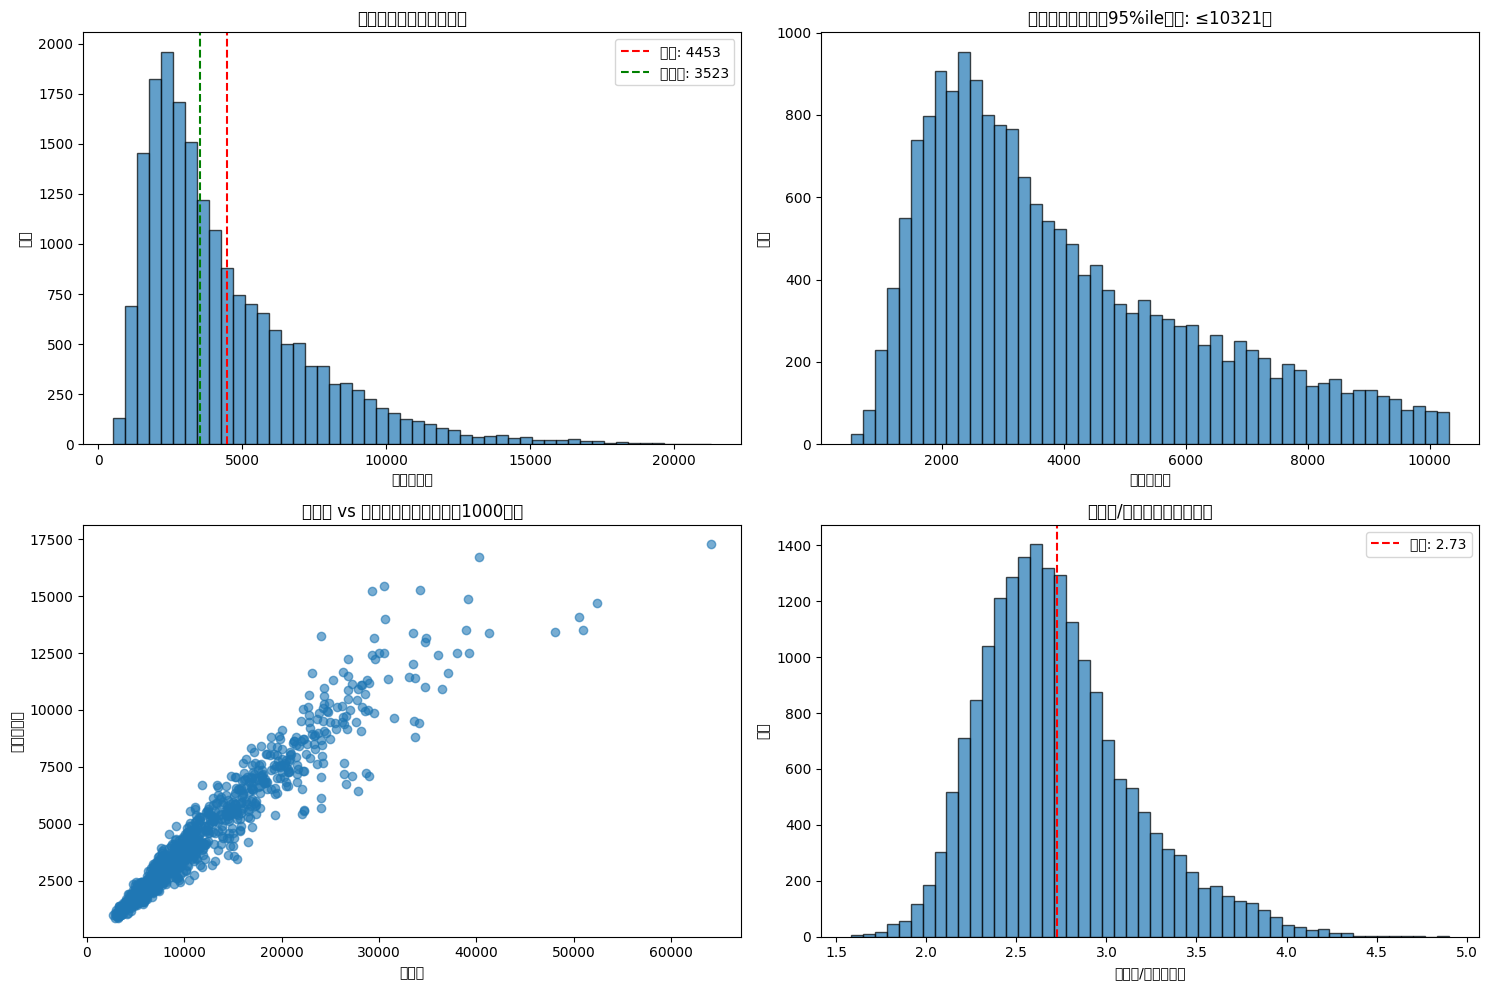

In [13]:
# トークン数分布のヒストグラム
plt.figure(figsize=(15, 10))

# 全体の分布
plt.subplot(2, 2, 1)
plt.hist(text_df['token_count'], bins=50, alpha=0.7, edgecolor='black')
plt.title('トークン数分布（全体）')
plt.xlabel('トークン数')
plt.ylabel('頻度')
plt.axvline(text_df['token_count'].mean(), color='red', linestyle='--', label=f'平均: {text_df["token_count"].mean():.0f}')
plt.axvline(text_df['token_count'].median(), color='green', linestyle='--', label=f'中央値: {text_df["token_count"].median():.0f}')
plt.legend()

# 95%ile以下に絞った分布
plt.subplot(2, 2, 2)
p95 = np.percentile(text_df['token_count'], 95)
filtered_tokens = text_df[text_df['token_count'] <= p95]['token_count']
plt.hist(filtered_tokens, bins=50, alpha=0.7, edgecolor='black')
plt.title(f'トークン数分布（95%ile以下: ≤{p95:.0f}）')
plt.xlabel('トークン数')
plt.ylabel('頻度')

# 文字数 vs トークン数の散布図
plt.subplot(2, 2, 3)
sample_idx = np.random.choice(len(text_df), min(1000, len(text_df)), replace=False)
sample_data = text_df.iloc[sample_idx]
plt.scatter(sample_data['combined_length'], sample_data['token_count'], alpha=0.6)
plt.title('文字数 vs トークン数（サンプル1000件）')
plt.xlabel('文字数')
plt.ylabel('トークン数')

# 文字数/トークン数比の分布
plt.subplot(2, 2, 4)
char_token_ratio = text_df['combined_length'] / text_df['token_count']
plt.hist(char_token_ratio, bins=50, alpha=0.7, edgecolor='black')
plt.title('文字数/トークン数比の分布')
plt.xlabel('文字数/トークン数')
plt.ylabel('頻度')
plt.axvline(char_token_ratio.mean(), color='red', linestyle='--', label=f'平均: {char_token_ratio.mean():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# 上位トークン数サンプルの一覧
print("=== 上位20サンプル（トークン数順） ===")
top_samples = text_df.nlargest(20, 'token_count')[['index', 'token_count', 'combined_length', 'problem_length', 'generated_solution_length']]
top_samples['char_token_ratio'] = top_samples['combined_length'] / top_samples['token_count']
print(top_samples.to_string(index=False))

=== 上位20サンプル（トークン数順） ===
 index  token_count  combined_length  problem_length  generated_solution_length  char_token_ratio
  2530        21292            42122              94                      42009          1.978302
  9240        20689            43937             183                      43735          2.123689
  1166        20445            35094              86                      34989          1.716508
  7145        20434            36044             151                      35874          1.763923
  7878        19776            36247             200                      36028          1.832878
  8390        19743            38181              53                      38109          1.933901
  1398        19645            33511             365                      33127          1.705828
 14891        19499            40527             200                      40308          2.078414
 14730        19483            49440             381                      49040          2.53

In [15]:
# トークン長区間別の分布
bins = [0, 1000, 2000, 4000, 8000, 16000, float('inf')]
labels = ['~1K', '1K-2K', '2K-4K', '4K-8K', '8K-16K', '16K+']
text_df['token_range'] = pd.cut(text_df['token_count'], bins=bins, labels=labels, right=False)

print("=== トークン長区間別分布 ===")
range_counts = text_df['token_range'].value_counts().sort_index()
range_percentage = (range_counts / len(text_df) * 100).round(2)

for range_name, count in range_counts.items():
    percentage = range_percentage[range_name]
    print(f"{range_name:>8}: {count:>6}件 ({percentage:>5.1f}%)")

print(f"\n総件数: {len(text_df)}")
print(f"最大トークン数: {text_df['token_count'].max()}")

=== トークン長区間別分布 ===
     ~1K:    207件 (  1.1%)
   1K-2K:   3135件 ( 16.3%)
   2K-4K:   7603件 ( 39.5%)
   4K-8K:   5968件 ( 31.0%)
  8K-16K:   2231件 ( 11.6%)
    16K+:    108件 (  0.6%)

総件数: 19252
最大トークン数: 21292


## 6. 結果のまとめ

In [16]:
# 結果サマリーを作成
summary = {
    'dataset_info': {
        'total_samples': len(text_df),
        'data_source': 'OpenMathReasoning train.parquet',
        'tokenizer_model': used_model
    },
    'token_statistics': {
        'max_tokens': int(text_df['token_count'].max()),
        'min_tokens': int(text_df['token_count'].min()),
        'mean_tokens': float(text_df['token_count'].mean()),
        'median_tokens': float(text_df['token_count'].median()),
        'std_tokens': float(text_df['token_count'].std())
    },
    'percentiles': {
        f'{p}th': float(np.percentile(text_df['token_count'], p))
        for p in [50, 75, 90, 95, 99]
    },
    'character_statistics': {
        'max_chars': int(text_df['combined_length'].max()),
        'mean_chars': float(text_df['combined_length'].mean()),
        'char_token_ratio': float((text_df['combined_length'] / text_df['token_count']).mean())
    }
}

print("=== 分析結果サマリー ===")
print(json.dumps(summary, indent=2, ensure_ascii=False))

# 結果をファイルに保存
output_path = "open_math_reasoning_mini_token_analysis_summary.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print(f"\n結果を保存しました: {output_path}")

=== 分析結果サマリー ===
{
  "dataset_info": {
    "total_samples": 19252,
    "data_source": "OpenMathReasoning train.parquet",
    "tokenizer_model": "Qwen/Qwen3-0.6B"
  },
  "token_statistics": {
    "max_tokens": 21292,
    "min_tokens": 508,
    "mean_tokens": 4453.369260336588,
    "median_tokens": 3523.0,
    "std_tokens": 2948.9988849178944
  },
  "percentiles": {
    "50th": 3523.0,
    "75th": 5842.0,
    "90th": 8542.600000000006,
    "95th": 10320.600000000006,
    "99th": 14702.430000000011
  },
  "character_statistics": {
    "max_chars": 69142,
    "mean_chars": 11861.161957199252,
    "char_token_ratio": 2.727649786244167
  }
}

結果を保存しました: open_math_reasoning_mini_token_analysis_summary.json
